In [1]:
import os
import json
import itertools
import skimage.io
import skimage.morphology
import matplotlib.colors
import matplotlib.animation

import numpy as np
import pandas as pd
import seaborn as sns
import skimage as ski
import matplotlib.pyplot as plt

import fractaltools

import scipy as sp
import scipy.optimize as op

from decimal import *
import collections

#from matplotlib2tikz import save as tikz_save

sns.set_context("paper")
sns.set_style("white")

%matplotlib notebook

In [2]:
def entropy(probabilities, order = 1):
    # Works for Decimal arrays
    
    if order in [0, 1]:
        probabilities = probabilities[np.nonzero(probabilities)]
    
    if order == 1:
        return sum([p * p.ln() for p in probabilities])
    
    elif order == 0:
        return (probabilities ** order).sum().ln() / Decimal(int(order) - 1)
    
    else:
        return (probabilities ** order).sum().ln() / Decimal(int(order) - 1)
        

        
def spectrum(points, powers, scales):
    
    if not isinstance(powers, np.ndarray):
        powers = np.array(powers)
        
        
    # order and remove offset
    points.sort()
    points = points - points[0]

    result = []
    for scale in scales:
        counts = collections.Counter(np.floor(points / scale)).values()
        # Convert to decimal
        counts = np.array(list(map(Decimal, counts)), dtype=np.dtype(Decimal))
        result.append(counts / counts.sum())

    slopes = []
    x = np.log(scales)

    for q in powers:
        y = [entropy(r, q) for r in result]
            
        A = np.vstack([x, np.ones(x.shape)]).T
        
        # TODO: add more info about the fit
        fit = np.linalg.lstsq(A,  np.array(y, dtype=np.float), rcond=-1)
        slopes.append(fit[0][0])

    # Compute the spectrum
    dq = np.array(slopes) 
    a  = np.gradient((powers - 1) * slopes, edge_order=2)
    f  = a * powers - (powers - 1) * slopes

    return a, f, dq

In [4]:
def image_spectrum(imagefilename, idx):
    region   = 3
    threshold= 7.0 / 255
    
    img      = ski.img_as_float(ski.io.imread(imagefilename.format(idx)))
    for k in range(1, 3):
        img += ski.img_as_float(ski.io.imread(imagefilename.format(idx + k)))
        
    img      = img / 3
    square   = ski.morphology.square(region * 2 + 1)
    
    img_bw   = ski.morphology.h_minima(img, threshold, square)
    
    img_reg  = ski.measure.label(img_bw, connectivity=2)
    reg_prop = ski.measure.regionprops(img_reg)

    centroids   = [r.centroid for r in reg_prop]
    incenter    = lambda x: np.sum((np.array(x) - 210) ** 2) < 38000
    centroids   = list(filter(incenter, centroids))
    
    x, y       = zip(*centroids)
        
    points     = fractaltools.cart2pol(centroids, (205, 205))
    rho, theta = zip(*points)
    
    powers     = list(range(-10, 11))
    scales     = np.pi / 2 ** np.array(range(5))
    
    a, f, dq   = spectrum(np.array(theta), powers, scales)
    a, f       = fractaltools.spectrum(np.array(theta), powers, scales)
    
    return a, f, dq

In [5]:
EXPERIMENT = [  
    "processed-data/plate-1-{0:03d}.png",
    "processed-data/plate-2-{0:03d}.png",
    "processed-data/plate-3-{0:03d}.png",
    "processed-data/plate-4-{0:03d}.png"]

In [6]:
# Save the aggregation spot position into a list of list of tuples

def find_aggregates(imagefilename, index):
    region   = 3
    threshold= 7.0 / 255
    
    img      = ski.img_as_float(ski.io.imread(imagefilename.format(index)))
    for k in range(1, 3):
        img += ski.img_as_float(ski.io.imread(imagefilename.format(index + k)))
        
    img      = img / 3
    square   = ski.morphology.square(region * 2 + 1)
    
    img_bw   = ski.morphology.h_minima(img, threshold, square)
    
    img_reg  = ski.measure.label(img_bw, connectivity=2)
    reg_prop = ski.measure.regionprops(img_reg)

    centroids   = [r.centroid for r in reg_prop]
    incenter    = lambda x: np.sum((np.array(x) - 210) ** 2) < 38000
    centroids   = list(filter(incenter, centroids))
    
    return centroids
    
    

result     = []
time_frame = [range(100, 160), range(120, 180), range(110, 170), range(63, 123)]


for exp in range(4):
    exp_sequence = []
    
    for t in time_frame[exp]:
        if t % 10 == 0:
            print("Precessing experiment {0:d} frame {1:d}".format(exp, t))
        
        exp_sequence.append(find_aggregates(EXPERIMENT[exp], t))
        
    result.append(exp_sequence)

Precessing experiment 0 frame 100
Precessing experiment 0 frame 110
Precessing experiment 0 frame 120
Precessing experiment 0 frame 130
Precessing experiment 0 frame 140
Precessing experiment 0 frame 150
Precessing experiment 1 frame 120
Precessing experiment 1 frame 130
Precessing experiment 1 frame 140
Precessing experiment 1 frame 150
Precessing experiment 1 frame 160
Precessing experiment 1 frame 170
Precessing experiment 2 frame 110
Precessing experiment 2 frame 120
Precessing experiment 2 frame 130
Precessing experiment 2 frame 140
Precessing experiment 2 frame 150
Precessing experiment 2 frame 160
Precessing experiment 3 frame 70
Precessing experiment 3 frame 80
Precessing experiment 3 frame 90
Precessing experiment 3 frame 100
Precessing experiment 3 frame 110
Precessing experiment 3 frame 120


In [7]:
data = {"info": "The data field is a list that includes other 4 lists, one for each experiment. Each list out of this 4 contains 60 lists, one for image. Each of these 60 lists one their own contain a list of tuples with the x and y coordinates of each aggregation spot detected in that image.", "data": result}

with open('aggregates.json', 'w') as f:
    json.dump(data, f, indent = 2, ensure_ascii = False)

In [8]:
time_frame = [range(100, 160), range(120, 180), range(110, 170), range(63, 123)]

Dq = []
A  = []
FA = []

for exp in range(4):
   
    Exp_Dq = []
    Exp_A  = []
    Exp_FA = []
    for i, idx in enumerate(time_frame[exp]):
        a, f, dq = image_spectrum(EXPERIMENT[exp], idx)

        Exp_Dq.append(dq)
        Exp_A.append(a)
        Exp_FA.append(f)
        
    
    Dq.append(Exp_Dq)
    A.append(Exp_A)
    FA.append(Exp_FA)

In [9]:
def self_organization(f, a0, a):
    return np.trapz((a0 - a) ** 2 * f, a)

def emergence(dDq, a, q):
    return np.trapz(dDq * np.abs(np.gradient(a, q[1] - q[0], edge_order=2)), q)

In [10]:
header = "time"
time   = np.array(list(range(58))) / 6.0
result = [time, ]
df     = pd.DataFrame()
q      = np.array(list(range(0, 11)))

for exp in range(4):    
    
    # Compute experiment metrics
    for i in range(58):
        d     = pd.DataFrame({
                     'Time': (i + 1) / 6.0, 
                     'Emergence': emergence((Dq[exp][i + 1] - Dq[exp][i])[10:], A[exp][i + 1][10:], q),
                     'Organization': self_organization(FA[exp][i], A[exp][i][11], A[exp][i]),
                     'Experiment': exp + 1}, [1])
        
        df    = df.append(d, ignore_index=True)
        
    # Export metrics
    dfe     = df.query("Experiment == {0}".format(exp + 1))
    header += " emergence{0:d} organization{0:d}".format(exp + 1)
    
    result.append(dfe['Emergence'])
    result.append(dfe['Organization'])
    

np.savetxt("metrics.txt", np.vstack(result).T, fmt = '%0.5f', header = header)

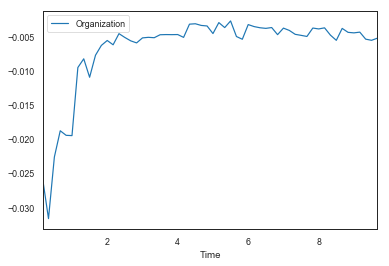

In [11]:
df.query("Experiment == 4").plot(x="Time", y="Organization")

/Users/valeriu/Software/Miniconda3/envs/bacteria-emergence/lib/python3.7/site-packages/seaborn/regression.py:279: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


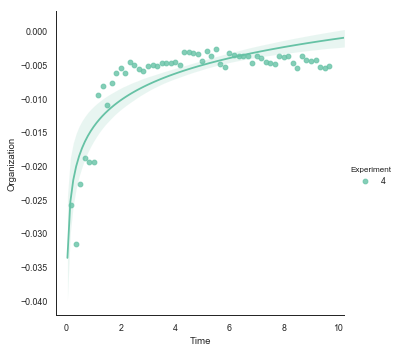

In [12]:
ax = sns.lmplot(x='Time', y='Organization', data=dfe, hue='Experiment', logx=True,  palette="Set2")

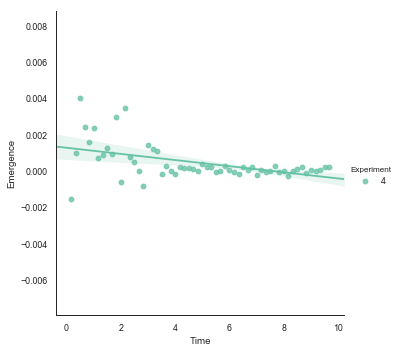

In [13]:
ax = sns.lmplot(x='Time', y='Emergence', data=dfe, hue='Experiment', order=1,  palette="Set2")